In [3]:
import pandas as pd
import numpy as np
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.image as mpimg
import math
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [3]:
df = pd.read_csv('../nss_capstone/df_rebuild.csv').drop(columns = 'Unnamed: 0').fillna('')

In [4]:
df = df.apply(pd.to_numeric, errors='coerce')

In [5]:
df.columns

Index(['game_id', 'Date', 'VH', 'Team', 'Final', 'ML', 'ML_pct', 'Open Total',
       'Close Total', 'Open Spread', 'Close Spread', 'W/L_fav', 'W/L_dog',
       'ATS_fav', 'W/L_H_fav', 'W/L_V_fav', 'W/L_H_dog', 'W/L_V_dog',
       'ATS_H_fav', 'ATS_V_fav', 'ATS_H_dog', 'ATS_V_dog', 'Push', 'W/L_bool'],
      dtype='object')

                                    ***********Gradient Boost******************

In [12]:
df = pd.read_csv('../nss_capstone/df_train_07_20.csv').drop(columns='Unnamed: 0')

variables = ['ML_pct',
             'Open Total',
            'Open Spread',
            'Close Total',
             'Close Spread']

X = df[variables]
y = df['W/L_bool']

grouped = df.groupby('game_id')
train_indices, test_indices = [], []
for _, group_indices in grouped.groups.items():
    group_train_indices, group_test_indices = train_test_split(group_indices, test_size=0.2, random_state=321)
    train_indices.extend(group_train_indices)
    test_indices.extend(group_test_indices)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

imputer = SimpleImputer(strategy='mean')

imputer.fit(X_train)

X_train_imputed = imputer.transform(X_train)
X_test_imputed = imputer.transform(X_test)

base_classifier = GradientBoostingClassifier()

calibrated_classifier = CalibratedClassifierCV(base_classifier, method='sigmoid', cv=5) # isotonic/ cv?

calibrated_classifier.fit(X_train_imputed, y_train)

probabilities = calibrated_classifier.predict_proba(X_test_imputed)

In [13]:
df_prob = pd.DataFrame(probabilities, columns=['Class 0 Probability', 'Class 1 Probability'])

In [14]:
df_prob

,Class 0 Probability,Class 1 Probability
0,0.668262,0.331738
1,0.592124,0.407876
2,0.476143,0.523857
3,0.741297,0.258703
4,0.316677,0.683323
...,...,...
6661,0.354305,0.645695
6662,0.268142,0.731858
6663,0.651660,0.348340
6664,0.860458,0.139542


In [15]:
df_val = pd.read_csv('../nss_capstone/df_val_21_22.csv').drop(columns='Unnamed: 0').fillna(0)

X_val_imputed = imputer.transform(df_val[variables])

probabilities = calibrated_classifier.predict_proba(X_val_imputed)

In [16]:
df_prob_val = pd.DataFrame(probabilities, columns=['Class 0 Probability', 'Class 1 Probability'])

In [17]:
df_prob_val

,Class 0 Probability,Class 1 Probability
0,0.410270,0.589730
1,0.593332,0.406668
2,0.417259,0.582741
3,0.595036,0.404964
4,0.416656,0.583344
...,...,...
2231,0.537857,0.462143
2232,0.417317,0.582683
2233,0.545089,0.454911
2234,0.441370,0.558630


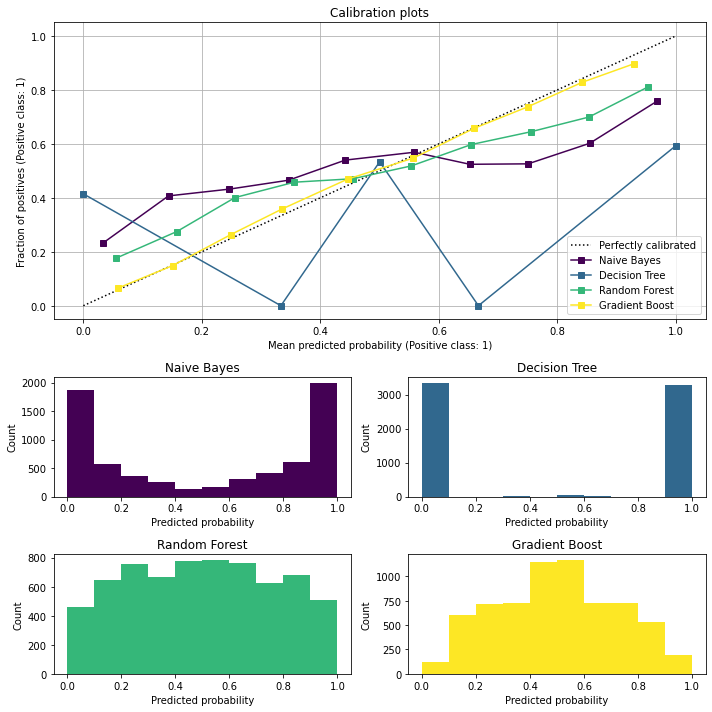

In [18]:
imputer = SimpleImputer(strategy='mean')

# Apply imputation on your training and test data
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

dt = DecisionTreeClassifier()
nb = GaussianNB()
rf = RandomForestClassifier()
grb = GradientBoostingClassifier()


# rf_isotonic = CalibratedClassifierCV(rf, cv=2, method='isotonic')
# rf_sigmoid = CalibratedClassifierCV(rf, cv=2, method='sigmoid')
# grb_isotonic = CalibratedClassifierCV(grb, cv=2, method='isotonic')
# grb_sigmoid = CalibratedClassifierCV(grb, cv=2, method='sigmoid')


clf_list = [
    (nb, 'Naive Bayes'),
    (dt, 'Decision Tree'),
    (rf, 'Random Forest'),
    (grb, 'Gradient Boost')
    #(rf_isotonic, 'Random Forest + Isotonic'),
    #(rf_sigmoid, 'Random Forest + Sigmoid'),
    #(grb_isotonic, 'Gradient Boost + Isotonic')
    #(grb_sigmoid, 'Gradient Boost + Sigmoid')
]

#court_image = mpimg.imread("path/to/basketball_court_image.jpg")

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("viridis", len(clf_list))

# ax_court = fig.add_subplot(gs[:, :])

# ax_court.imshow(court_image, aspect='auto', extent=[0, 1, 0, 1])


ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train_imputed, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test_imputed,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title('Calibration plots')

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1), (3, 1), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

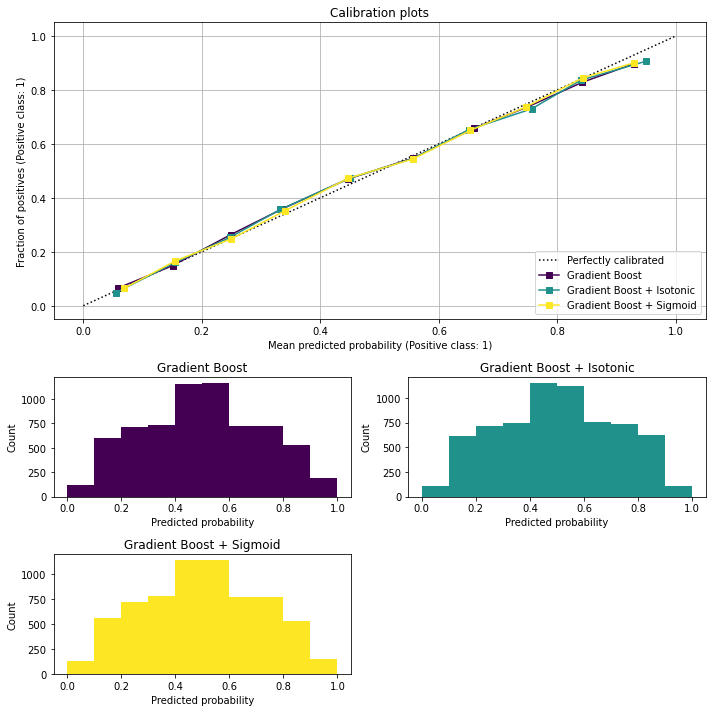

In [19]:
imputer = SimpleImputer(strategy='mean')

# Apply imputation on your training and test data
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

dt = DecisionTreeClassifier()
nb = GaussianNB()
rf = RandomForestClassifier()
grb = GradientBoostingClassifier()


# rf_isotonic = CalibratedClassifierCV(rf, cv=2, method='isotonic')
# rf_sigmoid = CalibratedClassifierCV(rf, cv=2, method='sigmoid')
grb_isotonic = CalibratedClassifierCV(grb, cv=2, method='isotonic')
grb_sigmoid = CalibratedClassifierCV(grb, cv=2, method='sigmoid')


clf_list = [
    #(nb, 'Naive Bayes'),
    #(dt, 'Decision Tree'),
    #(rf, 'Random Forest'),
    (grb, 'Gradient Boost'),
    #(rf_isotonic, 'Random Forest + Isotonic'),
    #(rf_sigmoid, 'Random Forest + Sigmoid'),
    (grb_isotonic, 'Gradient Boost + Isotonic'),
    (grb_sigmoid, 'Gradient Boost + Sigmoid')
]

#court_image = mpimg.imread("path/to/basketball_court_image.jpg")

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("viridis", len(clf_list))

# ax_court = fig.add_subplot(gs[:, :])

# ax_court.imshow(court_image, aspect='auto', extent=[0, 1, 0, 1])


ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train_imputed, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test_imputed,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title('Calibration plots')

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1), (3, 1), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

In [57]:
df_wager

,game_id,ML_fav,ML_dog,ML_fav_pct,ML_pct_dog,Class 0 Probability,Class 1 Probability,W/L_fav,W/L_dog,Payout_fav,Payout_dog
1,1,-155,135,60.79,42.56,41.85,41.85,1,0,64.52,135.0
2,2,-310,260,75.61,27.78,60.84,60.84,1,0,32.26,260.0
3,3,-135,115,57.45,46.52,26.99,26.99,1,0,74.08,115.0
4,4,-175,155,63.64,39.22,71.27,71.27,1,0,57.15,155.0
5,5,-185,165,64.92,37.74,46.54,46.54,1,0,54.06,165.0
...,...,...,...,...,...,...,...,...,...,...,...
660,660,-140,120,58.34,45.46,61.74,61.74,1,0,71.43,120.0
661,661,-105,-115,51.22,53.49,17.57,17.57,0,1,95.24,115.0
662,662,-175,155,63.64,39.22,61.15,61.15,0,1,57.15,155.0
663,663,-800,550,88.89,15.39,35.61,35.61,1,0,12.50,550.0


In [82]:
#df.loc[df['game_id'] == 17985]

In [24]:
df_val = pd.read_csv('../nss_capstone/df_val_21_22.csv').drop(columns = 'Unnamed: 0').fillna('')

In [25]:
df_val

,game_id,Date,VH,Team,Final,ML,ML_pct,Open Total,Close Total,Open Spread,...,W/L_V_fav,W/L_H_dog,W/L_V_dog,ATS_H_fav,ATS_V_fav,ATS_H_dog,ATS_V_dog,Push,W/L_bool,Payout
0,1,2022-06-16,H,Boston,90,-175.0,0.64,,,-2.5,...,0,0,0,0,0,0,0,0,0,57.15
1,1,2022-06-16,V,Golden State,103,155.0,0.39,212.5,211.5,2.5,...,0,0,1,0,0,0,0,0,1,155.00
2,2,2022-06-13,H,Golden State,104,-165.0,0.62,,,-3.5,...,0,0,0,1,0,0,0,0,1,60.61
3,2,2022-06-13,V,Boston,94,145.0,0.41,212.5,211.0,3.5,...,0,0,0,0,0,0,0,0,0,145.00
4,3,2022-06-10,H,Boston,97,-165.0,0.62,,,-2.5,...,0,0,0,0,0,0,0,0,0,60.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2231,1321,2021-10-20,H,Charlotte,123,105.0,0.49,,223.0,-2.0,...,0,1,0,0,0,0,0,0,1,105.00
2232,1322,2021-10-19,H,LALakers,114,-160.0,0.62,,,-4.5,...,0,0,0,0,0,0,0,0,0,62.50
2233,1322,2021-10-19,V,GoldenState,121,140.0,0.42,230.5,226.5,4.5,...,0,0,1,0,0,0,0,0,1,140.00
2234,1323,2021-10-19,H,Milwaukee,127,-125.0,0.56,,,-0.0,...,0,0,0,1,0,0,0,0,1,80.00


In [21]:
df['Payout'] = df.groupby('game_id')['ML'].transform(lambda x: (100 / abs(x.iloc[0])) * 100)


TypeError: bad operand type for abs(): 'str'

In [ ]:
df.loc[df.groupby('game_id').cumcount() > 0, 'Payout'] = None

In [17]:
df['Payout'] = pd.to_numeric(df['Payout'], errors='coerce')


KeyError: 'Payout'

In [147]:
df[[ 'game_id', 'Team','ML','ML_pct','Open Spread', 'Close Spread', 'W/L_bool', 'Payout']].head(16)

,game_id,Team,ML,ML_pct,Open Spread,Close Spread,W/L_bool,Payout
0,1,NaN,-175.0,63.64,-2.5,-4.0,0,57.142857
1,1,NaN,155.0,39.22,2.5,4.0,1,NaN
2,2,NaN,-165.0,62.26,-3.5,-4.0,1,60.606061
3,2,NaN,145.0,40.82,3.5,4.0,0,NaN
4,3,NaN,-165.0,62.26,-2.5,-4.0,0,60.606061
5,3,NaN,145.0,40.82,2.5,4.0,1,NaN
6,4,NaN,-155.0,60.78,-2.5,-3.5,1,64.516129
7,4,NaN,135.0,42.55,2.5,3.5,0,NaN
8,5,NaN,-200.0,66.67,-3.5,-5.0,1,50.000000
9,5,NaN,175.0,36.36,3.5,5.0,0,NaN


In [148]:

# # Replace NaN values in the second row with corresponding payout values
# second_row_mask = df.groupby('game_id').cumcount() == 1
# df.loc[second_row_mask, 'Payout'] = df.loc[second_row_mask, 'ML'].abs()

In [149]:
df[['ML', 'Payout']]

,ML,Payout
0,-175.0,57.142857
1,155.0,155.000000
2,-165.0,60.606061
3,145.0,145.000000
4,-165.0,60.606061
...,...,...
35969,190.0,190.000000
35970,-120.0,83.333333
35971,100.0,100.000000
35972,-1400.0,7.142857


In [140]:
df['Payout'] = pd.to_numeric(df['Payout'], errors='coerce')


In [150]:
df['Payout'] = df['Payout'].apply(lambda x: math.ceil(x * 100) / 100 if not math.isnan(x) else x)

In [151]:
df[[ 'game_id', 'Team','ML','ML_pct','Open Spread', 'Close Spread', 'W/L_bool', 'Payout']].head(16)

,game_id,Team,ML,ML_pct,Open Spread,Close Spread,W/L_bool,Payout
0,1,NaN,-175.0,63.64,-2.5,-4.0,0,57.15
1,1,NaN,155.0,39.22,2.5,4.0,1,155.00
2,2,NaN,-165.0,62.26,-3.5,-4.0,1,60.61
3,2,NaN,145.0,40.82,3.5,4.0,0,145.00
4,3,NaN,-165.0,62.26,-2.5,-4.0,0,60.61
5,3,NaN,145.0,40.82,2.5,4.0,1,145.00
6,4,NaN,-155.0,60.78,-2.5,-3.5,1,64.52
7,4,NaN,135.0,42.55,2.5,3.5,0,135.00
8,5,NaN,-200.0,66.67,-3.5,-5.0,1,50.00
9,5,NaN,175.0,36.36,3.5,5.0,0,175.00


In [118]:
# wager.to_csv('../nss_capstone/wager.csv')

In [66]:
wager = pd.read_csv('../nss_capstone/wager.csv').drop(columns = 'Unnamed: 0').fillna('')
df_wager = wager[['game_id','ML','ML_pct','Payout', 'W/L_bool']]

In [67]:
df_wager

,game_id,ML,ML_pct,Payout,W/L_bool
0,1,-155,60.79,64.52,1
1,1,135,42.56,135.00,0
2,2,-310,75.61,32.26,1
3,2,260,27.78,260.00,0
4,3,-135,57.45,74.08,1
...,...,...,...,...,...
1323,662,155,39.22,155.00,1
1324,663,-800,88.89,12.50,1
1325,663,550,15.39,550.00,0
1326,664,-280,73.69,35.72,1


In [68]:
df_wager['Game'] = (df_wager.index // 2) + 1

# Set multi-index by 'Game' and the row number within each game
df_wager.set_index(['Game', df_wager.groupby('Game').cumcount()], inplace=True)

# Unstack the DataFrame
pivoted_df = df_wager.unstack()

# Flatten the column index
pivoted_df.columns = [f'{col}_{num}' for col, num in pivoted_df.columns]

pivoted_df_wager = pd.DataFrame(pivoted_df)

pivoted_df_wager

C:\Users\tjsim\AppData\Local\Temp\ipykernel_65060\1622317668.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wager['Game'] = (df_wager.index // 2) + 1


,game_id_0,game_id_1,ML_0,ML_1,ML_pct_0,ML_pct_1,Payout_0,Payout_1,W/L_bool_0,W/L_bool_1
Game,,,,,,,,,,
1,1,1,-155,135,60.79,42.56,64.52,135.0,1,0
2,2,2,-310,260,75.61,27.78,32.26,260.0,1,0
3,3,3,-135,115,57.45,46.52,74.08,115.0,1,0
4,4,4,-175,155,63.64,39.22,57.15,155.0,1,0
5,5,5,-185,165,64.92,37.74,54.06,165.0,1,0
...,...,...,...,...,...,...,...,...,...,...
660,660,660,-140,120,58.34,45.46,71.43,120.0,1,0
661,661,661,-105,-115,51.22,53.49,95.24,115.0,0,1
662,662,662,-175,155,63.64,39.22,57.15,155.0,0,1


In [69]:
df_wager = pd.merge(pivoted_df_wager, df_prob_val, how='inner', left_index=True, right_index=True).drop(columns = 'game_id_0')

In [73]:
df_wager = df_wager.rename(columns = {'game_id_1': 'game_id', 'ML_0': 'ML_fav',
                       'ML_1': 'ML_dog', 'ML_pct_0':'ML_fav_pct',
                       'ML_pct_1': 'ML_pct_dog','Class 0 Probability': 'Predict_dog',
                        'Class 1 Probability': 'Predict_fav','Payout_0': 'Payout_fav',
                       'Payout_1': 'Payout_dog', 'W/L_bool_0': 'W/L_fav',
                       'W/L_bool_1':'W/L_dog'})

In [74]:
df_wager = df_wager[['game_id','ML_fav','ML_dog','ML_fav_pct','ML_pct_dog', 'Predict_fav','Predict_dog',
          'W/L_fav','W/L_dog','Payout_fav','Payout_dog']]

In [75]:
df_wager

,game_id,ML_fav,ML_dog,ML_fav_pct,ML_pct_dog,Predict_fav,Predict_dog,W/L_fav,W/L_dog,Payout_fav,Payout_dog
1,1,-155,135,60.79,42.56,0.418461,0.581539,1,0,64.52,135.0
2,2,-310,260,75.61,27.78,0.611705,0.388295,1,0,32.26,260.0
3,3,-135,115,57.45,46.52,0.269811,0.730189,1,0,74.08,115.0
4,4,-175,155,63.64,39.22,0.712687,0.287313,1,0,57.15,155.0
5,5,-185,165,64.92,37.74,0.465309,0.534691,1,0,54.06,165.0
...,...,...,...,...,...,...,...,...,...,...,...
660,660,-140,120,58.34,45.46,0.622990,0.377010,1,0,71.43,120.0
661,661,-105,-115,51.22,53.49,0.175666,0.824334,0,1,95.24,115.0
662,662,-175,155,63.64,39.22,0.613722,0.386278,0,1,57.15,155.0
663,663,-800,550,88.89,15.39,0.356065,0.643935,1,0,12.50,550.0


In [55]:
df_wager['Class 0 Probability'] = df_wager['Class 0 Probability'] * 100
df_wager['Class 1 Probability'] = df_wager['Class 1 Probability'] * 100

In [76]:
df_wager['Predict_dog'] = df_wager['Predict_dog'].apply(lambda x: math.ceil(x * 100) / 100 if not math.isnan(x) else x) * 100 
df_wager['Predict_fav'] = df_wager['Predict_fav'].apply(lambda x: math.ceil(x * 100) / 100 if not math.isnan(x) else x) * 100

In [77]:
df_wager

,game_id,ML_fav,ML_dog,ML_fav_pct,ML_pct_dog,Predict_fav,Predict_dog,W/L_fav,W/L_dog,Payout_fav,Payout_dog
1,1,-155,135,60.79,42.56,42.0,59.0,1,0,64.52,135.0
2,2,-310,260,75.61,27.78,62.0,39.0,1,0,32.26,260.0
3,3,-135,115,57.45,46.52,27.0,74.0,1,0,74.08,115.0
4,4,-175,155,63.64,39.22,72.0,29.0,1,0,57.15,155.0
5,5,-185,165,64.92,37.74,47.0,54.0,1,0,54.06,165.0
...,...,...,...,...,...,...,...,...,...,...,...
660,660,-140,120,58.34,45.46,63.0,38.0,1,0,71.43,120.0
661,661,-105,-115,51.22,53.49,18.0,83.0,0,1,95.24,115.0
662,662,-175,155,63.64,39.22,62.0,39.0,0,1,57.15,155.0
663,663,-800,550,88.89,15.39,36.0,65.0,1,0,12.50,550.0


                                ***************Gradient Boost************************

In [ ]:
#df = pd.read_csv('../nss_capstone/df_rebuild.csv').drop(columns = 'Unnamed: 0').fillna('')

In [24]:
df = df.apply(pd.to_numeric, errors='coerce')

In [28]:
variables = ['ML_pct',
#             'Open Total',
#             'Open Spread',
            'Close Total',
            'Close Spread']

X = df[variables]
y = df['W/L_bool']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

imputer = SimpleImputer(strategy='mean')

imputer.fit(X_train)

X_train_imputed = imputer.transform(X_train)
X_test_imputed = imputer.transform(X_test)

base_classifier = GradientBoostingClassifier()

calibrated_classifier = CalibratedClassifierCV(base_classifier, method='sigmoid', cv=5)

calibrated_classifier.fit(X_train_imputed, y_train)

probabilities = calibrated_classifier.predict_proba(X_test_imputed)

In [29]:
df_prob = pd.DataFrame(probabilities, columns=['Class 0 Probability', 'Class 1 Probability'])

In [30]:
df_prob

,Class 0 Probability,Class 1 Probability
0,0.585932,0.414068
1,0.739284,0.260716
2,0.772641,0.227359
3,0.119857,0.880143
4,0.868415,0.131585
...,...,...
7190,0.650938,0.349062
7191,0.682925,0.317075
7192,0.586458,0.413542
7193,0.804976,0.195024


In [31]:
df_val = pd.read_csv('../nss_capstone/df_val.csv').drop(columns='Unnamed: 0').fillna(0)

X_val_imputed = imputer.transform(df_val[variables])

probabilities = calibrated_classifier.predict_proba(X_val_imputed)

In [32]:
df_prob_val = pd.DataFrame(probabilities, columns=['Class 0 Probability', 'Class 1 Probability'])

In [33]:
df_prob_val.head(13)

,Class 0 Probability,Class 1 Probability
0,0.367910,0.632090
1,0.572923,0.427077
2,0.399133,0.600867
3,0.771944,0.228056
4,0.287318,0.712682
5,0.560134,0.439866
6,0.424516,0.575484
7,0.643706,0.356294
8,0.398210,0.601790
9,0.672634,0.327366


In [71]:
wager = pd.read_csv('../nss_capstone/df_val.csv').drop(columns='Unnamed: 0').fillna(0)

In [78]:
wager[[ 'game_id', 'Team','ML','ML_pct', 'W/L_bool']].head(16)

,game_id,Team,ML,ML_pct,W/L_bool
0,1,Boston,-155,60.78,1
1,1,Philadelphia,155,39.22,0
2,2,GoldenState,-310,75.61,1
3,2,LALakers,310,24.39,0
4,3,Washington,-135,57.45,1
5,3,Indiana,135,42.55,0
6,4,Detroit,-175,63.64,1
7,4,Orlando,175,36.36,0
8,5,Memphis,-185,64.91,1
9,5,NewYork,185,35.09,0


                        *************DECISION TREE*******************

In [44]:
variables = ['ML_pct',
#             'Open Total',
#             'Open Spread',
            'Close Total',
            'Close Spread']

X = df[variables]
y = df['W/L_bool']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

imputer = SimpleImputer(strategy='mean')

imputer.fit(X_train)

X_train_imputed = imputer.transform(X_train)
X_test_imputed = imputer.transform(X_test)

base_classifier = DecisionTreeClassifier()

calibrated_classifier = CalibratedClassifierCV(base_classifier, method='sigmoid', cv=5)

calibrated_classifier.fit(X_train_imputed, y_train)

probabilities = calibrated_classifier.predict_proba(X_test_imputed)

In [45]:
df_prob = pd.DataFrame(probabilities, columns=['Class 0 Probability', 'Class 1 Probability'])

In [46]:
df_prob

,Class 0 Probability,Class 1 Probability
0,0.504574,0.495426
1,0.509524,0.490476
2,0.685328,0.314672
3,0.389051,0.610949
4,0.685328,0.314672
...,...,...
7190,0.571139,0.428861
7191,0.685328,0.314672
7192,0.386134,0.613866
7193,0.537799,0.462201


In [47]:
df_val = pd.read_csv('../nss_capstone/df_val.csv').drop(columns='Unnamed: 0').fillna(0)

X_val_imputed = imputer.transform(df_val[variables])

probabilities = calibrated_classifier.predict_proba(X_val_imputed)

In [48]:
df_prob_val = pd.DataFrame(probabilities, columns=['Class 0 Probability', 'Class 1 Probability'])

In [49]:
df_prob_val

,Class 0 Probability,Class 1 Probability
0,0.449407,0.550593
1,0.457268,0.542732
2,0.542112,0.457888
3,0.612385,0.387615
4,0.380896,0.619104
...,...,...
1323,0.469582,0.530418
1324,0.509500,0.490500
1325,0.685328,0.314672
1326,0.606606,0.393394


In [73]:
wager = pd.read_csv('../nss_capstone/df_val.csv').drop(columns='Unnamed: 0').fillna(0)

In [79]:
wager[[ 'game_id', 'Team','ML','ML_pct', 'W/L_bool']].head(16)

,game_id,Team,ML,ML_pct,W/L_bool
0,1,Boston,-155,60.78,1
1,1,Philadelphia,155,39.22,0
2,2,GoldenState,-310,75.61,1
3,2,LALakers,310,24.39,0
4,3,Washington,-135,57.45,1
5,3,Indiana,135,42.55,0
6,4,Detroit,-175,63.64,1
7,4,Orlando,175,36.36,0
8,5,Memphis,-185,64.91,1
9,5,NewYork,185,35.09,0


                        *******************NAIVE BAYES***********************

In [36]:

variables = ['ML_pct',
#             'Open Total',
#             'Open Spread',
            'Close Total',
            'Close Spread']

X = df[variables]
y = df['W/L_bool']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

imputer = SimpleImputer(strategy='mean')

imputer.fit(X_train)

X_train_imputed = imputer.transform(X_train)
X_test_imputed = imputer.transform(X_test)

base_classifier = GaussianNB()

calibrated_classifier = CalibratedClassifierCV(base_classifier, method='sigmoid', cv=5)

calibrated_classifier.fit(X_train_imputed, y_train)

probabilities = calibrated_classifier.predict_proba(X_test_imputed)

In [37]:
df_prob = pd.DataFrame(probabilities, columns=['Class 0 Probability', 'Class 1 Probability'])

In [38]:
df_prob

,Class 0 Probability,Class 1 Probability
0,0.688711,0.311289
1,0.763661,0.236339
2,0.729117,0.270883
3,0.244127,0.755873
4,0.764080,0.235920
...,...,...
7190,0.690116,0.309884
7191,0.699117,0.300883
7192,0.753524,0.246476
7193,0.745158,0.254842


In [39]:
df_val = pd.read_csv('../nss_capstone/df_val.csv').drop(columns='Unnamed: 0').fillna(0)

X_val_imputed = imputer.transform(df_val[variables])

probabilities = calibrated_classifier.predict_proba(X_val_imputed)

In [40]:
df_prob_val = pd.DataFrame(probabilities, columns=['Class 0 Probability', 'Class 1 Probability'])

In [41]:
df_prob_val

,Class 0 Probability,Class 1 Probability
0,0.771188,0.228812
1,0.656538,0.343462
2,0.771188,0.228812
3,0.758739,0.241261
4,0.771188,0.228812
...,...,...
1323,0.764189,0.235811
1324,0.771188,0.228812
1325,0.770463,0.229537
1326,0.771188,0.228812


In [75]:
wager = pd.read_csv('../nss_capstone/df_val.csv').drop(columns='Unnamed: 0').fillna(0)

In [80]:
wager[[ 'game_id', 'Team','ML','ML_pct', 'W/L_bool']].head(16)

,game_id,Team,ML,ML_pct,W/L_bool
0,1,Boston,-155,60.78,1
1,1,Philadelphia,155,39.22,0
2,2,GoldenState,-310,75.61,1
3,2,LALakers,310,24.39,0
4,3,Washington,-135,57.45,1
5,3,Indiana,135,42.55,0
6,4,Detroit,-175,63.64,1
7,4,Orlando,175,36.36,0
8,5,Memphis,-185,64.91,1
9,5,NewYork,185,35.09,0
